<a href="https://colab.research.google.com/github/MrCogito/SpecGan/blob/main/Data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generate spectrogram**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import os
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Inzynierka/Models/vctk_female/dataset/Female_small.zip -d /content/vctk > /dev/null 

# Set parameters


In [ ]:
audio_folder = '/content/vctk'
dataset_tensor_folder = '/content/gdrive/MyDrive/Inzynierka/Models/vctk_female/dataset'
#audio_trim_folder = '/content/gdrive/MyDrive/Inzynierka/Data_new/audio_trim_folder/'
dataset_tensor = np.empty((0,128,88))
TENSOR_NAME = "tensor_vctk_female"
TARGET_SIZE = 16000                     
TARGET_SAMPLING_RATE=8000
SPLIT_DURATION = 2          # in seconds
#spectrogram_tensor = np.load('/content/gdrive/MyDrive/Inzynierka/Data/en_spectrogram_tensor/Dataset_mel_spectrogram_256_8_3.npy')

# Split clips augumentation 

In [ ]:
## data augumentation 
#Split audio clip into smaller pieces
def split_audio_clip(path, duration):
  audio, sr = librosa.load(path)
  audio, index = librosa.effects.trim(audio, top_db = 15) 
  buffer = duration * sr

  samples_total = len(audio)
  samples_wrote = 0
  counter = 1

  while samples_wrote < samples_total:

    #check if the buffer is not exceeding total samples 
    if (samples_total - samples_wrote) < (buffer * 2):
      buffer = samples_total - samples_wrote
    block = audio[samples_wrote : (samples_wrote + buffer)]
    out_filename = path + str(counter) + "split.wav"

    sf.write(out_filename, block, sr)
    counter += 1
    samples_wrote += buffer 
  os.remove(path)


In [ ]:
def split_clips(folder_path,duration):

  for root, dirs, files in os.walk(folder_path):
    for name in files:
        print(os.path.join(root, name))   
        split_audio_clip(os.path.join(root, name,), duration)
    for name in dirs:
        print(os.path.join(root, name))
       

  for root, dirs, files in os.walk(folder_path):
    for name in files:
      print(os.path.join(root, name))     
      if not (name.endswith("split.wav")):
        os.remove(os.path.join(root, name,))  


In [ ]:
split_clips(audio_folder,SPLIT_DURATION)

Streaming output truncated to the last 5000 lines.
/content/Dogs/dogs/dogs_0467.wav
/content/Dogs/dogs/dogs_0464.wav
/content/Dogs/dogs/dogs_0407.wav
/content/Dogs/dogs/dogs_0243.wav
/content/Dogs/dogs/dogs_0095.wav
/content/Dogs/dogs/dogs_0930.wav
/content/Dogs/dogs/dogs_0201.wav
/content/Dogs/dogs/dogs_0742.wav
/content/Dogs/dogs/dogs_0794.wav
/content/Dogs/dogs/dogs_0326.wav
/content/Dogs/dogs/dogs_0525.wav
/content/Dogs/dogs/dogs_0620.wav
/content/Dogs/dogs/dogs_0212.wav
/content/Dogs/dogs/dogs_0800.wav
/content/Dogs/dogs/dogs_0795.wav
/content/Dogs/dogs/dogs_0435.wav
/content/Dogs/dogs/dogs_0843.wav
/content/Dogs/dogs/dogs_0064.wav
/content/Dogs/dogs/dogs_0646.wav
/content/Dogs/dogs/dogs_0922.wav
/content/Dogs/dogs/dogs_0147.wav
/content/Dogs/dogs/dogs_0044.wav
/content/Dogs/dogs/dogs_0946.wav
/content/Dogs/dogs/dogs_0630.wav
/content/Dogs/dogs/dogs_0625.wav
/content/Dogs/dogs/dogs_0939.wav
/content/Dogs/dogs/dogs_0903.wav
/content/Dogs/dogs/dogs_1022.wav
/content/Dogs/dogs/dogs_0

# Create mel spectrograms


In [ ]:
#Create MEL  - spectrograms
i = 0
assert os.path.isdir(os.path.join(dataset_tensor_folder)) == True
for root, dirs, files in os.walk(audio_folder):
  for name in files:
    #print(name)
    if name.endswith("flac"):
      audio_file, sr = librosa.load(os.path.join(root,name))  
      #print(sr)                                                                                                        
      #print(audio_file.dtype)
      audio_file_trim, index = librosa.effects.trim(audio_file, top_db = 15)                                                # Trim silnce with threshold equal to 15dB
      audio_file_trim_4k = librosa.resample(audio_file_trim, sr, target_sr = sr)                                            # resample TARGET_SAMPLING_RATE
      audio_fix_length = librosa.util.fix_length(audio_file_trim_4k, 2*sr, axis=- 1)                                        # get same length in all clip, zero padding  
      Spectrogram = librosa.feature.melspectrogram(audio_fix_length, sr=sr, n_fft=2048, hop_length=505, n_mels=128)         #create Mel spectrogram
      S_DB = librosa.power_to_db(Spectrogram, ref=np.max)
      tensor_spectrogram = tf.convert_to_tensor(S_DB)                                                                       # convert to tensor
      tensor_spectrogram = tf.expand_dims(tensor_spectrogram, axis=0)   
      #print(tensor_spectrogram.shape) 
      dataset_tensor = tf.concat([dataset_tensor, tensor_spectrogram], 0)
      np.save("testowy" ,dataset_tensor)
      i = i +1
      print(i)
      

np.save(os.path.join(dataset_tensor_folder , TENSOR_NAME), dataset_tensor)
print(dataset_tensor.shape)


Streaming output truncated to the last 5000 lines.
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10476
10477
10478
10479
10480
10481
10482
10483
10484
10485
10486
10487
10488
10489
10490
10491
10492
10493
10494
10495
10496
10497
10498
10499
10500
10501
10502
10503
10504
10505
10506
10507
10508
10509
10510
10511
10512
10513
10514
10515
10516
10517
10518
10519
10520
10521
10522
10523
10524
10525
10526
10527
10528
10529
10530
1

# Create Spectograms


In [ ]:
#Create spectrograms

i=0
for root, dirs, files in os.walk(audio_folder):
  for name in files:
   
    if name.endswith("wav"):
      #print(os.path.join(root,name))
      audio_file, sr = librosa.load(os.path.join(root,name))                                                       
      #print(audio_file.dtype)
      #audio_file_trim, index = librosa.effects.trim(audio_file, top_db = 15)                                          # Trim silnce with threshold equal to 15dB
      audio_file_fix_length = librosa.util.fix_length(audio_file, sr*2, axis=- 1)
      print("DURATION: " + str(librosa.get_duration(audio_file_fix_length,sr=22050)))                                  # get same length in all clips  (2s)   
      spectrogram = np.abs(librosa.stft(audio_file_fix_length,n_fft=2046, hop_length=700))                             # create spectrogram.  n_fft size set to 510 to get 256 x n shape of spectrogram  
      tensor_spectrogram = tf.convert_to_tensor(spectrogram)                                                           # convert to tensor
      tensor_spectrogram = tf.expand_dims(tensor_spectrogram, axis=0)   
      #print(tensor_spectrogram.shape)
      dataset_tensor = tf.concat([dataset_tensor,tensor_spectrogram], 0)
      print(dataset_tensor.shape) 

np.save(os.path.join(dataset_tensor_folder , TENSOR_NAME), dataset_tensor)


# Mel-Spectrograms to audio 



(10, 128, 88)
Max value in data tensor: 1.9073486e-06
Min value in data tensor: -80.0
Max value in data tensor: 0.0
Min value in data tensor: -80.0


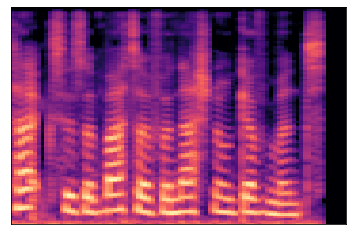

In [ ]:
loaded = np.load('/content/testowy.npy')
print(loaded.shape)

## squeeze if its generated spectrogram
if loaded.ndim == 4:
  loaded = np.squeeze(loaded)


#print("Max value in data tensor: " + str(np.max(loaded)))
#print("Min value in data tensor: " + str(np.min(loaded)))
#loaded = (loaded *80)-80           // normalize to (-80, 0)

print("Max value in data tensor: " + str(np.max(spec_gen)))
print("Min value in data tensor: " + str(np.min(spec_gen)))
#print(spec_gen)
librosa.display.specshow(spec_gen)
P = librosa.db_to_power(spec_gen, ref=1.0)
S = librosa.feature.inverse.mel_to_stft(P,sr=22050, n_fft=2048)
y = librosa.griffinlim(S)
#print(y.shape)
ipd.Audio(y, rate=22050)

# Spectrograms to audio 


(1, 128, 88, 1)
float32
(128, 88)


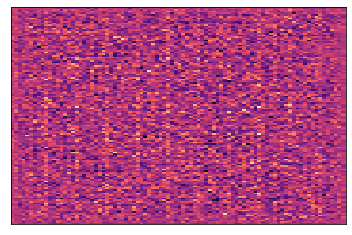

In [ ]:
loaded_real = np.load('/content/gdrive/MyDrive/Inzynierka/testgen.npy')
print(loaded_real.shape)
print(loaded_real.dtype)

## squeeze if its generated spectrogram
if loaded.ndim == 4:
  loaded = np.squeeze(loaded)

spec = loaded_real[0]
print(spec.shape)
librosa.display.specshow(spec)
audio = librosa.istft(stft_matrix=spec, win_length=2046, hop_length=700)

#print(np.amax(loaded_real))
#print(np.amin(loaded_real))
ipd.Audio(audio, rate=22050)
